# Text-To-Image Generation

The goal of this project is to get a better understanding of how text-to-image generation such as in [DALL·E 2](https://openai.com/de-DE/index/dall-e-2/) or similar models work. This work was also inspired by the [Guest video of WelchLabsVideo on the channel of 3Blue1Brown](https://www.youtube.com/watch?v=iv-5mZ_9CPY).

This Notebook accompanies this GitHub repository and should function as a demo and exploration ground. It will demonstrate how to use the code and visualize results.


In [26]:
# imports
from models import ClipModel, SimpleImageEncoder, LSTMTextEncoder, ConditionalUNet, DiffusionModel
from dataloading import load_mnist, CharacterTokenizer

from utils import *

SEED = 42
set_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## CLIP - Contrastive Language-Image Pre-training
CLIP was proposed by OpenAI in the paper of [Radford et al. (2021)](https://arxiv.org/pdf/2103.00020). The goal of CLIP is to train a text encoder and an image encoder to share the same embedding space. For example the image of a dog is mapped to the same vector as the description of that dog image. The image below illustrates this idea.

![clip objective](res/clip_objective.png)

The following sections will use the MNIST dataset to implement these ideas since it is a small dataset that allows for fast training.

In [2]:
description_encoder = CharacterTokenizer('abcdefghijklmnopqrstuvwxyz1234567890 .!?')
classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

_, validation_loader = load_mnist(encoder=description_encoder, batch_size=128, num_workers=4)

For the image encoder, this project uses a simple CNN architecture with three convolutional layer and two linear layers at the end. For the text encoder, a three-layer LSTM was used which reads each character of the description as its own token and then produces an output vector of the whole input. For the text encoding it is important that the encoder always produces token-vectors of the same length independent of the length of the description. Otherwise, if we would dynamically pad the sequences to the longest one in the batch we will get troubles later on when we want to generate a single digit as the LSTM encoder might rely too much on the padding for shorter inputs such as 'six' and produce nonsensical outputs. The tokenized sequence length size is fixed to 10 (excluding START and END token).

With these batches of image and text encodings, a similarity matrix is computed. The objective of the CLIP optimization process is then to maximize the similarity between the images and their corresponding descriptions (the diagonals) while minimizing the similarities with other descriptions. For this a special loss function is implemented in ````models/clip.py````. Other than that, training the models is rather standard.

After training the model, we can load it and investigate the results:

In [3]:
CLIP_MODEL_PATH = 'mnist_clip.pth'
CLIP_EMBEDDING_DIM = 2

clip_model = ClipModel(image_encoder=SimpleImageEncoder(), text_encoder=LSTMTextEncoder(description_encoder.alphabet_size), clip_embedding_dim=CLIP_EMBEDDING_DIM)
clip_model = load_model(clip_model, CLIP_MODEL_PATH).to(device).eval()

Loading model from mnist_clip.pth


### Image classification through embeddings
We can use the learned image embeddings for classification. For that we simply compute the image embedding and compare with the embeddings of the possible classes. Finally, we can report the class with the highest similarity.

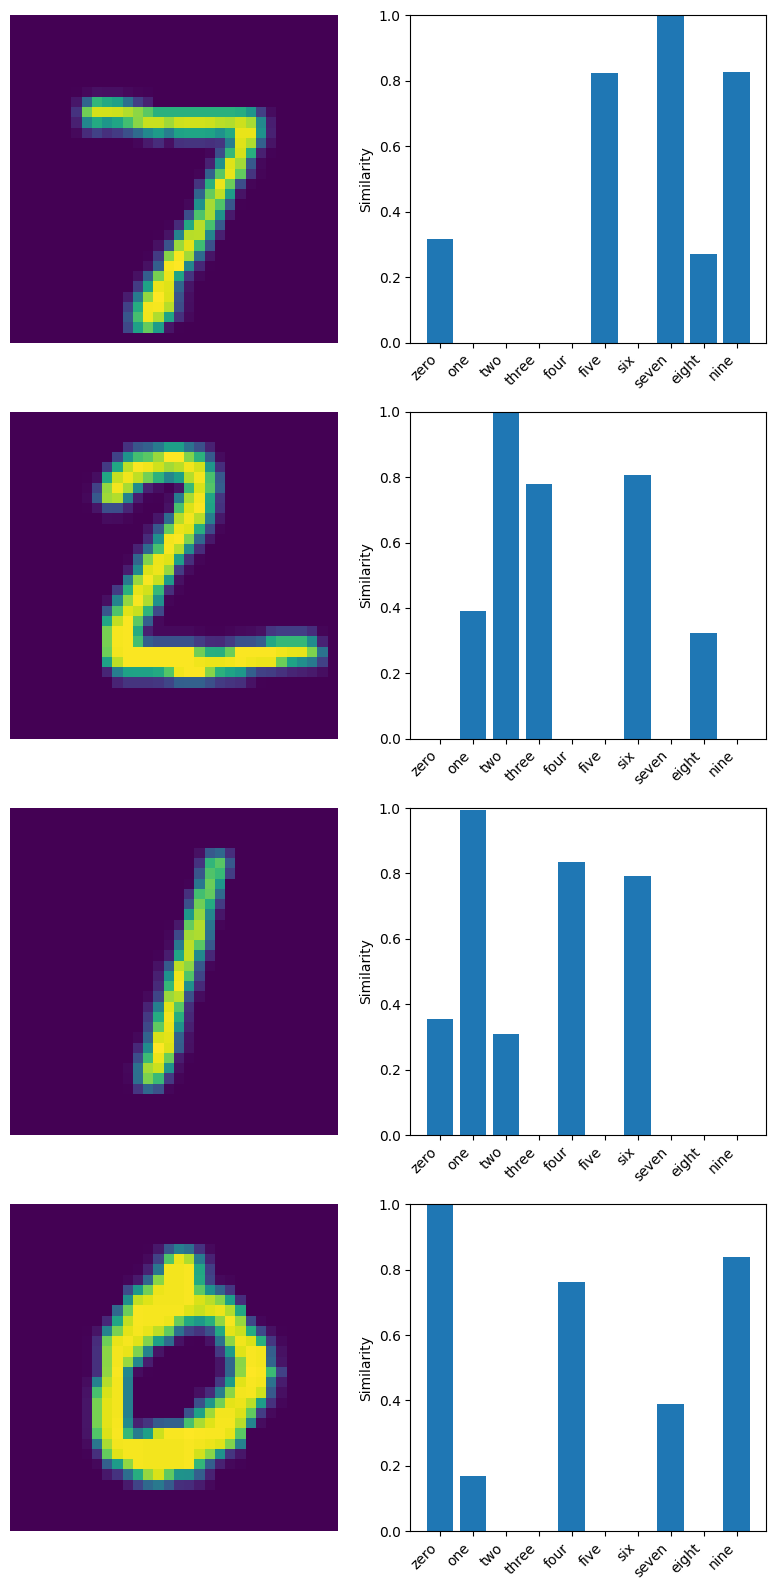

In [4]:
images, _ = next(iter(validation_loader))
show_clip_image_classification(images[:4], classes, clip_model, description_encoder, device)


As we can see the correct class has the highest similarity with the image embedding. Due to the low number of dimensions for the embedding space we get some close calls with other classes. This could be avoided with a larger number of embedding dimensions but for the purpose of showing the results this should do.

### Visualizing the embedding space
Using the MNIST dataset allows us to drastically reduce the dimensions for the embedding space. For the trained model it was lowered to two which we can nicely visualize in this section.

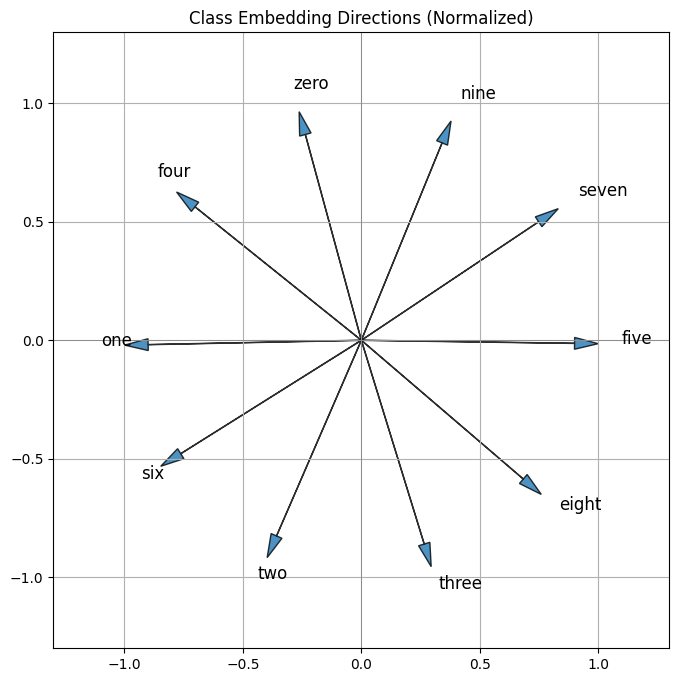

In [5]:
plot_class_embedding_directions(classes, clip_model, description_encoder, device)

Here we can see that the model has learned to give each number its own direction and spread them out as good as possible.

## UnCLIP - Image generation from text embeddings
The next step is to use these description embeddings to guide a diffusion model to generate the correct images from text inputs. For this, the diffusion model is not only conditioned on the time-step in the diffusion Markov Chain (see [Ho et al. (2020)](https://arxiv.org/abs/2006.11239) for more details) but also on the description embedding produced by the trained CLIP model.

The denoising diffusion model in this project is a simple U-Net architecture. It uses sinusoidal time embeddings and the clip description embeddings to condition the layers during training and generation. After training is finished, we can load the diffusion model and give it a text-prompt to generate digits.

Loading model from mnist_ddpm.pth
1001


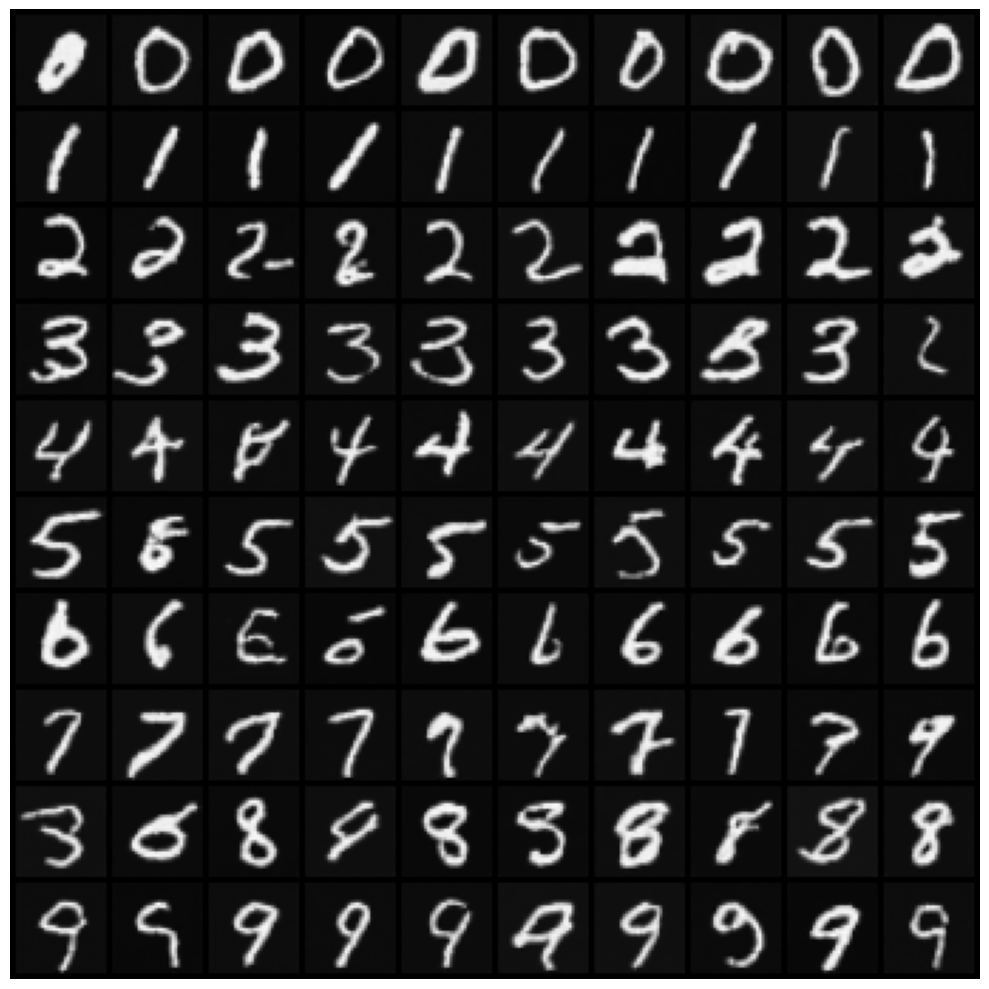

In [27]:
DIFFUSION_MODEL_PATH = 'mnist_ddpm.pth'
TIME_EMBEDDING_DIM = 128

unet = ConditionalUNet(in_channels=1, time_embedding_dim=TIME_EMBEDDING_DIM, clip_embedding_dim=CLIP_EMBEDDING_DIM)
ddpm = DiffusionModel(network=unet, max_steps=1000, min_beta=0.0001, max_beta=0.02)
ddpm = load_model(ddpm, DIFFUSION_MODEL_PATH).to(device).to(device).eval()

# Prompt several samples per digit
SAMPLES_PER_DIGIT = 10
max_sequence_length = len(max(classes, key=len))

generation_prompt = torch.stack(
    [description_encoder('zero')]*SAMPLES_PER_DIGIT +
    [description_encoder('one')]*SAMPLES_PER_DIGIT +
    [description_encoder('two')]*SAMPLES_PER_DIGIT +
    [description_encoder('three')]*SAMPLES_PER_DIGIT +
    [description_encoder('four')]*SAMPLES_PER_DIGIT +
    [description_encoder('five')]*SAMPLES_PER_DIGIT +
    [description_encoder('six')]*SAMPLES_PER_DIGIT +
    [description_encoder('seven')]*SAMPLES_PER_DIGIT +
    [description_encoder('eight')]*SAMPLES_PER_DIGIT +
    [description_encoder('nine')]*SAMPLES_PER_DIGIT
).to(device)

generation_prompt_embedding = clip_model.get_text_embeddings(generation_prompt)
generated_images, trajectory = ddpm.sample_new_images(num_samples=generation_prompt_embedding.shape[0], clip_embedding=generation_prompt_embedding)
print(len(trajectory))

# Show the digits one row at a time
plot_image_batch(generated_images, n_row=SAMPLES_PER_DIGIT)

## Interpolating between numbers
With the embedding space, we can also interpolate between two numbers and see how the image generation handles this case.

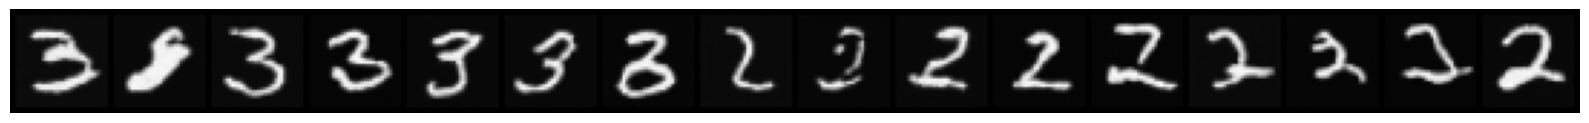

In [7]:
START_CLASS = 'three'
END_CLASS   = 'two'
STEPS = 16

clip_embeddings = clip_model.get_text_embeddings(torch.stack([description_encoder(START_CLASS), description_encoder(END_CLASS)]).to(device))

start_embedding = clip_model.get_text_embeddings(description_encoder(START_CLASS)[None, :].to(device))
end_embedding = clip_model.get_text_embeddings(description_encoder(END_CLASS)[None, :].to(device))
interpolations = [torch.lerp(start_embedding, end_embedding, alpha) for alpha in torch.linspace(0, 1, steps=STEPS)]

embeddings = torch.stack(interpolations).squeeze().to(device)
generated_images = ddpm.sample_new_images(num_samples=STEPS, clip_embedding=embeddings)
plot_image_batch(generated_images, n_row=STEPS)

These results show that it is possible to interpolate in the embedding space to go from one digit to another. However, the quality of these results are rather poor in this implementation.